In [1]:
import warnings
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import itertools
init_notebook_mode(connected=True)
sys.path.append("C:/dev/pycmqlib3/")
sys.path.append("C:/dev/pycmqlib3/misc_scripts/")
warnings.filterwarnings('ignore')
import misc
import data_handler as dh
import plotly_examples
import backtest
import alphalens as al
%matplotlib inline

In [2]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'ZC', 'SM', "SF"]
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg']
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'UR']
ags_all_mkts = ags_oil_mkts + ags_soft_mkts
eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF']
fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts
sim_start_dict = { 'c': datetime.date(2008,10,1), 'm': datetime.date(2010,10,1),
    'y': datetime.date(2010,1,1), 'l': datetime.date(2008,1,1), 'rb':datetime.date(2010,1,1),
    'p': datetime.date(2010,1,1), 'cu':datetime.date(2010,1,1), 'al':datetime.date(2010,1,1),
    'zn':datetime.date(2010,1,1), 'au':datetime.date(2010,1,1), 'v': datetime.date(2010,1,1),
    'a': datetime.date(2010,1,1), 'ru':datetime.date(2010,1,1), 'ag':datetime.date(2012,7,6),
    'i': datetime.date(2013,12,13), 'j': datetime.date(2011,6,14), 'jm':datetime.date(2013,5,24),
    'CF':datetime.date(2008,1,1),  'TA':datetime.date(2007,2,15),
    'PM':datetime.date(2012,10,1), 'RM':datetime.date(2013,3,16),  'SR':datetime.date(2006,1,6),
    'FG':datetime.date(2013,2,1),  'OI':datetime.date(2013,6,1),  'RI':datetime.date(2013,6,1),
    'WH':datetime.date(2014,2,1),  'pp':datetime.date(2014,4,28),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2011,12,23),  'TF':datetime.date(2014,4,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,17),
    'jd':datetime.date(2014,1,6),  'ni':datetime.date(2015,5,26),  'sn':datetime.date(2015,6,8),
    'ZC':datetime.date(2013,12,28), 'hc':datetime.date(2014, 5, 21), 'SM': datetime.date(2016,11,21),
    'SF': datetime.date(2017,5,17), 'CY': datetime.date(2017, 7, 17), 'AP': datetime.date(2018, 2, 26),
    'TS': datetime.date(2018, 8, 17), 'fu': datetime.date(2018, 7, 16), 'sc': datetime.date(2018, 5, 25),
    'b': datetime.date(2017, 12, 26), 'pb': datetime.date(2011, 5, 24), 'bu': datetime.date(2015,11,1),
    'T':datetime.date(2015,6,1), 'ss': datetime.date(2020, 4, 1), 'sp': datetime.date(2019, 1, 24),
    'CJ': datetime.date(2019, 8, 1), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2019, 12, 9),
    'eb': datetime.date(2019, 12, 1), 'eg': datetime.date(2019, 2, 13), 'rr': datetime.date(2019, 8, 19),
    'pg': datetime.date(2020, 10, 1), 'lu': datetime.date(2020, 8, 1),}

In [3]:
field_list = ['open', 'high', 'low', 'close', 'volume', 'openInterest', 'contract', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2020,10,12)

sim_products = commod_all_mkts
need_shift = 1
freq = 'd'
delim = '-'

args = {'n': 1, 'roll_rule': '-35b', 'freq': freq, 'need_shift': need_shift, 'dbtbl_prefix': 'hist_'}
ferrous_products_args = args
ferro_mixed_mkt_args = args
base_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift}
eq_args = {'n': 1, 'roll_rule': '-1b', 'freq': freq, 'need_shift': need_shift}
bond_args = {'n': 1, 'roll_rule': '-30b', 'freq': freq, 'need_shift': need_shift}
precious_args = {'n': 1, 'roll_rule': '-25b', 'freq': freq, 'need_shift': need_shift}

df_list = []
for idx, asset in enumerate(sim_products):
    use_args = args
    if asset in eq_fut_mkts:
        use_args = eq_args
    elif asset in ['cu', 'al', 'zn', 'pb', 'sn']:
        use_args = base_args
    elif asset in bond_fut_mkts:
        use_args = bond_args
    elif asset in precious_metal_mkts:
        use_args = precious_args
    use_args['start_date'] = max(sim_start_dict[asset], start_date)
    use_args['end_date'] = end_date
    print("loading mkt = %s, args = %s" % (asset, use_args))
    df = misc.nearby(asset, **use_args)
    if freq == 'm':
        df = misc.cleanup_mindata(df, asset)
    if (idx == 0) and (freq == 'm'):
        df_list.append(df[['date', 'min_id']])
    xdf = df[field_list]
    xdf.columns = [delim.join((asset, col)) for col in xdf.columns]
    df_list.append(xdf)

df = pd.concat(df_list, axis = 1, sort = False)


loading mkt = rb, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': 'hist_', 'start_date': datetime.date(2010, 1, 1), 'end_date': datetime.date(2020, 10, 13)}
loading mkt = hc, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': 'hist_', 'start_date': datetime.date(2014, 5, 21), 'end_date': datetime.date(2020, 10, 13)}
loading mkt = i, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': 'hist_', 'start_date': datetime.date(2013, 12, 13), 'end_date': datetime.date(2020, 10, 13)}
loading mkt = j, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': 'hist_', 'start_date': datetime.date(2011, 6, 14), 'end_date': datetime.date(2020, 10, 13)}
loading mkt = jm, args = {'n': 1, 'roll_rule': '-35b', 'freq': 'd', 'need_shift': 1, 'dbtbl_prefix': 'hist_', 'start_date': datetime.date(2013, 5, 24), 'end_date': datetime.date(2020, 10, 13)}
loading mkt = ru, args = {'n': 1, 'ro

loading mkt = ag, args = {'n': 1, 'roll_rule': '-25b', 'freq': 'd', 'need_shift': 1, 'start_date': datetime.date(2012, 7, 6), 'end_date': datetime.date(2020, 10, 13)}


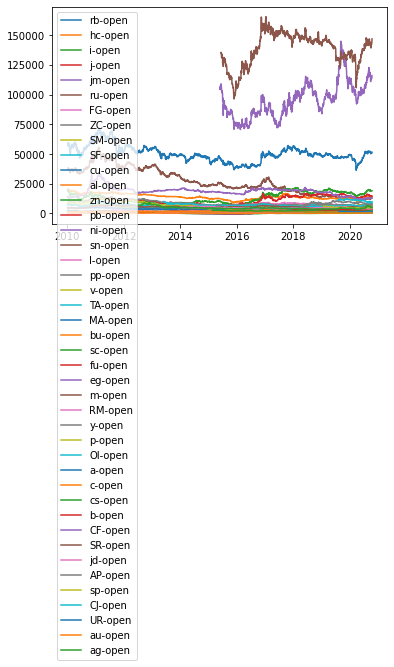

In [6]:
df[[prod+'-'+'open' for prod in sim_products]].plot()
plt.show()